In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Balancer"
SPLITS_FREQ = "3d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = None


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 602 non-null    object        
 1   author             602 non-null    object        
 2   date               602 non-null    datetime64[us]
 3   start              602 non-null    datetime64[us]
 4   end                602 non-null    datetime64[us]
 5   platform_proposal  602 non-null    object        
 6   title              602 non-null    object        
 7   description        602 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 37.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111987 entries, 0 to 111986
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        111987 non-null  object        
 1   proposal  111987 non-null

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x28143659f4500411d9e49513b88e66cdf81f9002,e41b9c54-4da0-554e-ad10-8a2397d4c2b2,2020-07-18 16:12:04,1
1,0x4aa2c2c321d86e6ce9c5b1fad7c2e084d867dea3,f3a84703-d173-500e-83e5-d5314a5946ef,2020-07-18 16:12:18,1
2,0x911f80d16ec1b70db332227b03beb871ac58ead7,f3a84703-d173-500e-83e5-d5314a5946ef,2020-07-18 16:12:22,1
3,0xd98e44d09660a89022515d6d41662d05a14253e7,f3a84703-d173-500e-83e5-d5314a5946ef,2020-07-18 16:12:39,1
4,0xd98e44d09660a89022515d6d41662d05a14253e7,e41b9c54-4da0-554e-ad10-8a2397d4c2b2,2020-07-18 16:13:31,1
...,...,...,...,...
111982,0xff0281256b2a478905b79895c1a2038a679e1751,4db5212d-7350-5ffd-b666-e43118aa20c0,2023-07-17 16:45:33,1
111983,0x222e3cb8d92bc316e9dc8b45eb218702bf94f9c1,44450f97-8c69-529b-b201-e7c5322ee709,2023-07-17 17:55:48,1
111984,0x222e3cb8d92bc316e9dc8b45eb218702bf94f9c1,3c092794-ba86-54f3-a760-ceb90c1e4c11,2023-07-17 17:56:20,1
111985,0x222e3cb8d92bc316e9dc8b45eb218702bf94f9c1,9fe9a5b6-9833-5801-8fcb-fa5eaa560791,2023-07-17 17:56:48,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2023-06-18 00:00:00'),
 Timestamp('2023-06-21 00:00:00'),
 Timestamp('2023-06-24 00:00:00'),
 Timestamp('2023-06-27 00:00:00'),
 Timestamp('2023-06-30 00:00:00'),
 Timestamp('2023-07-03 00:00:00'),
 Timestamp('2023-07-06 00:00:00'),
 Timestamp('2023-07-09 00:00:00'),
 Timestamp('2023-07-12 00:00:00'),
 Timestamp('2023-07-15 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/Balancer/hparams-pln-similarity_3d_normalize.pkl with 280 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2023-06-18,all-mpnet-base-v2,7d,0.104803,0.001388,13,0.692308,0.641026,0.584615,0.469231,...,0.926693,1.0,1.0,0.275522,0.493910,0.631517,0.768590,0.825000,0.825000,0.130984
1,2023-06-18,all-mpnet-base-v2,14d,0.136711,0.001477,18,0.722222,0.685185,0.622222,0.522222,...,0.830817,1.0,1.0,0.227728,0.452244,0.579930,0.760256,0.850000,0.850000,0.131290
2,2023-06-18,all-mpnet-base-v2,21d,0.315768,0.001501,19,0.736842,0.666667,0.610526,0.510526,...,0.902879,1.0,1.0,0.282891,0.485427,0.610157,0.772906,0.856667,0.856667,0.130906
3,2023-06-18,all-mpnet-base-v2,30d,0.226878,0.001741,24,0.541667,0.555556,0.508333,0.420833,...,0.914779,1.0,1.0,0.227728,0.434386,0.550168,0.724542,0.814286,0.814286,0.132814
4,2023-06-18,all-mpnet-base-v2,60d,0.770948,0.002140,25,0.560000,0.573333,0.528000,0.428000,...,0.908188,1.0,1.0,0.220391,0.443761,0.568490,0.731239,0.815000,0.815000,0.133154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023-07-15,all-MiniLM-L6-v2,21d,0.276595,0.001682,61,0.491803,0.497268,0.531148,0.534426,...,0.743742,1.0,1.0,0.137408,0.266369,0.386084,0.626218,0.736967,0.736967,0.156772
276,2023-07-15,all-MiniLM-L6-v2,30d,0.316524,0.001736,64,0.593750,0.520833,0.537500,0.543750,...,0.758287,1.0,1.0,0.145435,0.268533,0.388520,0.631500,0.746074,0.746074,0.157515
277,2023-07-15,all-MiniLM-L6-v2,60d,0.276458,0.002025,71,0.563380,0.492958,0.512676,0.509859,...,0.776618,1.0,1.0,0.127747,0.257836,0.392810,0.632966,0.742765,0.742765,0.187294
278,2023-07-15,all-MiniLM-L6-v2,90d,0.790655,0.002443,72,0.569444,0.504630,0.516667,0.501389,...,0.763848,1.0,1.0,0.128696,0.257836,0.402054,0.641240,0.753376,0.753376,0.160607


<Axes: xlabel='window_size', ylabel='map@10'>

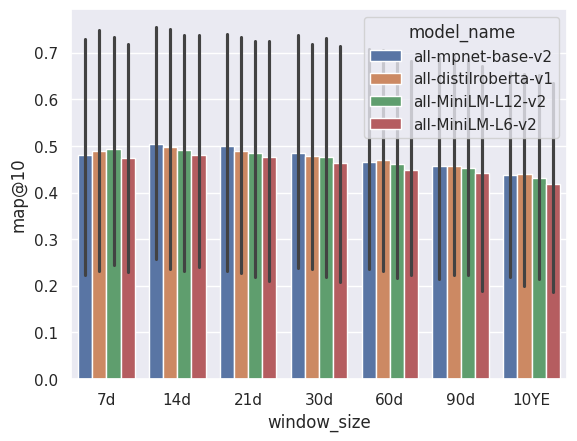

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                    
14d         all-mpnet-base-v2       0.182581     0.388449      0.266119   
            all-distilroberta-v1    0.237238     0.393671      0.265465   
21d         all-mpnet-base-v2       0.260854     0.378463      0.263560   
7d          all-distilroberta-v1    0.226879     0.360821      0.240099   
21d         all-distilroberta-v1    0.211530     0.387407      0.264107   
7d          all-MiniLM-L12-v2       0.227105     0.342747      0.236924   
30d         all-mpnet-base-v2       0.316775     0.374282      0.262303   
14d         all-MiniLM-L12-v2       0.216602     0.370890      0.263940   
30d         all-distilroberta-v1    0.338105     0.382581      0.263171   
            all-MiniLM-L12-v2       0.326504     0.369953      0.260741   
21d         all-MiniLM-L12-v2       0.188332     0.367643      0.261739   
14d         all-MiniLM-L6-v2        0.200167     0.368366      0.262851   
21d         all-MiniLM-L6-v2        0.203872     0.366112      0.260464   
30d         all-MiniLM-L6-v2        0.326599     0.363855      0.259873   
7d          all-MiniLM-L6-v2        0.190072     0.340750      0.236924   
60d         all-distilroberta-v1    0.449677     0.373417      0.254545   
7d          all-mpnet-base-v2       0.225127     0.358345      0.240099   
60d         all-mpnet-base-v2       0.446198     0.352682      0.252823   
            all-MiniLM-L12-v2       0.377598     0.353191      0.251728   
90d         all-distilroberta-v1    1.454047     0.364593      0.249304   
            all-MiniLM-L12-v2       1.286122     0.343503      0.245754   
            all-mpnet-base-v2       1.450511     0.341851      0.246989   
60d         all-MiniLM-L6-v2        0.376886     0.352477      0.251102   
90d         all-MiniLM-L6-v2        1.286855     0.346904      0.246063   
10YE        all-MiniLM-L12-v2      30.003414     0.325119      0.235750   
            all-distilroberta-v1   33.190533     0.348908      0.239970   
            all-mpnet-base-v2      33.211924     0.329342      0.236313   
            all-MiniLM-L6-v2       30.005829     0.327643      0.235328   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
14d         all-mpnet-base-v2          0.028268  0.338753  0.349650  0.352473   
            all-distilroberta-v1       0.028268  0.339792  0.347263  0.350043   
21d         all-mpnet-base-v2          0.028068  0.364505  0.380993  0.384864   
7d          all-distilroberta-v1       0.025319  0.205349  0.210407  0.211517   
21d         all-distilroberta-v1       0.028068  0.368210  0.379566  0.382897   
7d          all-MiniLM-L12-v2          0.025319  0.199702  0.209338  0.211753   
30d         all-mpnet-base-v2          0.027984  0.385704  0.403325  0.407465   
14d         all-MiniLM-L12-v2          0.028268  0.325213  0.344057  0.348295   
30d         all-distilroberta-v1       0.027984  0.387501  0.401717  0.405206   
            all-MiniLM-L12-v2          0.027984  0.381073  0.400390  0.405771   
21d         all-MiniLM-L12-v2          0.028068  0.355604  0.376665  0.382289   
14d         all-MiniLM-L6-v2           0.028268  0.320009  0.338686  0.343414   
21d         all-MiniLM-L6-v2           0.028068  0.350586  0.371379  0.377804   
30d         all-MiniLM-L6-v2           0.027984  0.374306  0.395777  0.401926   
7d          all-MiniLM-L6-v2           0.025319  0.195039  0.204962  0.207396   
60d         all-distilroberta-v1       0.026957  0.418700  0.433326  0.436756   
7d          all-mpnet-base-v2          0.025319  0.197876  0.204332  0.205592   
60d         all-mpnet-base-v2          0.026957  0.402563  0.429724  0.434641   
            all-MiniLM-L12-v2          0.026957  0.402661  0.429874  0.435813   
90d         all-distilroberta-v1       0.026458  0.423418  0.440535  0.444486   
 

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Balancer/models/plnsim-best-avg_3d_normalize.parquet


/tmp/ipykernel_3808364/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2023-06-18,14d,all-mpnet-base-v2,0.136711,0.001477,18,0.722222,0.685185,0.622222,0.522222,0.433333,0.065000,0.419355,...,0.830817,1.0,1.0,0.227728,0.452244,0.579930,0.760256,0.850000,0.850000,0.131290
2023-06-21,14d,all-mpnet-base-v2,0.144593,0.000401,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066356
2023-06-24,14d,all-mpnet-base-v2,0.125720,0.001445,40,0.875000,0.775000,0.790000,0.520000,0.346667,0.052000,0.603448,...,1.000000,1.0,1.0,0.246735,0.491865,0.746164,0.882407,0.882407,0.882407,0.137245
2023-06-27,14d,all-mpnet-base-v2,0.288536,0.000376,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066597
2023-06-30,14d,all-mpnet-base-v2,0.129898,0.001690,76,0.802632,0.798246,0.784211,0.535526,0.357018,0.053553,0.592233,...,1.000000,1.0,1.0,0.170570,0.474442,0.744122,0.905208,0.905208,0.905208,0.154145
2023-07-03,14d,all-mpnet-base-v2,0.126476,0.001375,10,0.900000,0.833333,0.780000,0.500000,0.333333,0.050000,0.818182,...,1.000000,1.0,1.0,0.285714,0.523810,0.761905,0.888889,0.888889,0.888889,0.125890
2023-07-06,14d,all-mpnet-base-v2,0.128887,0.000371,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066376
2023-07-09,14d,all-mpnet-base-v2,0.286430,0.001363,18,1.000000,0.870370,0.522222,0.261111,0.174074,0.026111,0.500000,...,1.000000,1.0,1.0,0.453704,1.000000,1.000000,1.000000,1.000000,1.000000,0.124799
2023-07-12,14d,all-mpnet-base-v2,0.291587,0.000374,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067166


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/Balancer/models/plnsim-best-val_3d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-06-18,all-mpnet-base-v2,21d,0.315768,0.610526,0.510526,0.062105,0.482961,0.509193,0.520052,0.748465,0.756239,0.777670,0.600124,0.902879,1.0,0.610157,0.772906,0.856667
2023-06-21,all-mpnet-base-v2,7d,0.267535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2023-06-24,all-distilroberta-v1,7d,0.255599,0.792000,0.528000,0.052800,0.387976,0.400791,0.400791,0.860167,0.892627,0.892627,0.790190,1.000000,1.0,0.732091,0.888406,0.888406
2023-06-27,all-MiniLM-L6-v2,10YE,29.914414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2023-06-30,all-distilroberta-v1,7d,0.264300,0.865517,0.567241,0.056724,0.510595,0.523583,0.523583,0.877653,0.895105,0.895105,0.770484,1.000000,1.0,0.768040,0.914103,0.914103
2023-07-03,all-mpnet-base-v2,14d,0.126476,0.780000,0.500000,0.050000,0.868241,0.866353,0.866353,0.933333,0.926190,0.926190,0.835714,1.000000,1.0,0.761905,0.888889,0.888889
2023-07-06,all-distilroberta-v1,60d,0.385636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2023-07-09,all-mpnet-base-v2,21d,0.146312,0.514286,0.257143,0.025714,0.583333,0.583333,0.583333,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
2023-07-12,all-mpnet-base-v2,60d,0.324680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,3.212182,0.418194,0.294134,0.032009,0.328965,0.337695,0.341321,0.505117,0.513732,0.519300,0.448889,0.572855,0.600000,0.433658,0.516478,0.535127
std,9.382630,0.373730,0.268067,0.029944,0.309992,0.314157,0.316322,0.445832,0.451371,0.454098,0.408797,0.496129,0.516398,0.396330,0.451605,0.463127
min,0.121104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.265917,0.562406,0.378571,0.037857,0.422259,0.447244,0.459944,0.690006,0.711700,0.739540,0.546251,0.864277,1.000000,0.537274,0.736690,0.829935
75%,0.322452,0.739902,0.523632,0.055743,0.503687,0.519986,0.522700,0.873282,0.894486,0.894486,0.785264,1.000000,1.000000,0.754451,0.888768,0.888768
max,29.914414,0.865517,0.578431,0.072745,0.868241,0.866353,0.866353,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Balancer/models/plnsim-best-test_3d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-06-21,all-mpnet-base-v2,21d,0.327061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2023-06-24,all-mpnet-base-v2,7d,0.254470,0.784000,0.528000,0.052800,0.374605,0.393964,0.393964,0.831756,0.872197,0.872197,0.746857,1.000000,1.0,0.746584,0.902899,0.902899
2023-06-27,all-distilroberta-v1,7d,0.259365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2023-06-30,all-MiniLM-L6-v2,10YE,29.918837,0.633010,0.466990,0.046699,0.704068,0.814220,0.814220,0.645688,0.735963,0.735963,0.621012,1.000000,1.0,0.680098,0.856838,0.856838
2023-07-03,all-distilroberta-v1,7d,0.262149,0.560000,0.340000,0.034000,0.401793,0.401164,0.401164,0.833333,0.828571,0.828571,0.909524,1.000000,1.0,0.761905,0.833333,0.833333
2023-07-06,all-mpnet-base-v2,14d,0.128887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2023-07-09,all-distilroberta-v1,60d,0.366879,0.483871,0.241935,0.024194,0.814565,0.814565,0.814565,0.927419,0.927419,0.927419,1.000000,1.000000,1.0,0.982143,0.982143,0.982143
2023-07-12,all-mpnet-base-v2,21d,0.155794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2023-07-15,all-mpnet-base-v2,60d,0.316157,0.504225,0.525352,0.067606,0.499590,0.601512,0.645765,0.487504,0.556988,0.599215,0.404199,0.813841,1.0,0.382600,0.617473,0.721476


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,3.554400,0.329456,0.233586,0.025033,0.310514,0.336158,0.341075,0.413967,0.435682,0.440374,0.409066,0.534871,0.555556,0.394814,0.465854,0.477410
std,9.886962,0.324126,0.238728,0.026553,0.324580,0.351320,0.355779,0.412102,0.425863,0.427595,0.422500,0.510827,0.527046,0.404429,0.452291,0.457943
min,0.128887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.254470,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.262149,0.483871,0.241935,0.024194,0.374605,0.393964,0.393964,0.487504,0.556988,0.599215,0.404199,0.813841,1.000000,0.382600,0.617473,0.721476
75%,0.327061,0.560000,0.466990,0.046699,0.499590,0.601512,0.645765,0.831756,0.828571,0.828571,0.746857,1.000000,1.000000,0.746584,0.856838,0.856838
max,29.918837,0.784000,0.528000,0.067606,0.814565,0.814565,0.814565,0.927419,0.927419,0.927419,1.000000,1.000000,1.000000,0.982143,0.982143,0.982143
